# Jaccard en folio

In [13]:
import os
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import FeatureHasher

pd.set_option('display.max_columns',900)

Cargamos la base

In [4]:
fname = './datos/cortes/w18/enasama_2024W18_0429_0505.pkl'
df_w18 = pd.read_pickle(fname)

In [21]:
hasher = FeatureHasher(n_features=100, input_type='string')


In [22]:
n_gramas_folios = []
for folio in df_w18.folio[:10]:
    sep = [folio[i:i+2] for i in range(0,len(folio)-2)]
    n_gramas_folios.append(sep)



In [27]:
transf = hasher.fit_transform(n_gramas_folios)

In [35]:
folio_nuevo = '161020001080002116003010'
carac_nuevo = [folio_nuevo[i:i+2] for i in range(0, len(folio_nuevo)-2)]


<22x100 sparse matrix of type '<class 'numpy.float64'>'
	with 38 stored elements in Compressed Sparse Row format>

In [33]:
transf.toarray().shape

(10, 100)

In [5]:
df_w18.folio

0        161020001080002116003009
1        161020001080002116003009
2        161020001080002616003005
3        161020001176200216003004
4        161020001176200216003004
                   ...           
36064    240420001012900124004401
36065    240420001012900124004402
36066    240420001012900124004402
36067    240420001012900324004401
36068    240420001012900324004401
Name: folio, Length: 36069, dtype: object

In [6]:
entidad = df_w18[df_w18.entidad=='Aguascalientes']

## Índice de Jaccard

El índice de Jacard se calcula como y mide el grado de similitud entre dos conjuntos

$$
J(a,b) = \frac {|a\cap b|} {|a \cup b|}
$$

Específicamente mide el tamaño de la intersección de símbolos de la cadena a y b respecto de unión de símbolos.Si los conjuntos a y b son iguales entonces el índice es 0 y si son muy diferentes entonces el resultado tiende a 1.

Se puede hacer directamente con las cadenas pero lo vamos a intentar haciendo n-gramas.

In [37]:
def ngramas(c, n=3):
    """
    Convierte una cadena c en paquetes de 
    n-gramas
    
    - Parameters:
        c: cadena a dividir
        n: tamaño del n-garma
    
    - Returns:
        Lista con cadena c dividia en n-gramas
    """
    tr = [c[i:i+n] for i in range(len(c)-n+1)]
    return tr

def jaccard(a,b):
    """
    Índice de Jaccard entre a y b
    
    - Parameters:
        a y b: Listas de objeteos
    
    - Returns:
        Float con índice de jaccard
    """
    union = set(a).union(set(b))
    inter = set(a).intersection(set(b))
    return len(inter) / len(union)

In [38]:
folio1 = entidad.folio.iloc[0]
ngramas(folio1)

['010',
 '100',
 '001',
 '010',
 '100',
 '000',
 '000',
 '001',
 '019',
 '193',
 '937',
 '371',
 '719',
 '190',
 '900',
 '001',
 '010',
 '100',
 '001',
 '012',
 '120',
 '206']

In [39]:
folio1 = entidad.folio.iloc[0]
folio2 = entidad.folio.iloc[2]

jaccard(ngramas(folio1), ngramas(folio2)), folio1, folio2

(0.75, '010010000193719001001206', '010010000193719001001211')

In [40]:
folio1  = entidad.folio.iloc[0]
folio2  = entidad.folio.iloc[1]
folio3  = entidad.folio.iloc[2]
folio4  = entidad.folio.iloc[3]
folio5  = entidad.folio.iloc[4]
folio6  = entidad.folio.iloc[5]
folio7  = entidad.folio.iloc[6]
folio8  = entidad.folio.iloc[7]
folio9  = entidad.folio.iloc[8]
folio10 = entidad.folio.iloc[9]
folio11 = entidad.folio.iloc[10]
folio12 = entidad.folio.iloc[11]

In [120]:
# matriz de scores 
# de indices de jaccard entre todos 
# los folios
M = np.zeros((len(entidad),len(entidad)))

# para cada folio i
# lo comparamos con folio j
for i in range(M.shape[0]):
    folio_i = entidad.folio.iloc[i]
    for j in range(M.shape[1]):
        folio_j = entidad.folio.iloc[j]
        M[i,j] = jaccard(ngramas(folio_i), ngramas(folio_j))

In [121]:
M

array([[1.        , 1.        , 0.75      , ..., 0.18181818, 0.16666667,
        0.18181818],
       [1.        , 1.        , 0.75      , ..., 0.18181818, 0.16666667,
        0.18181818],
       [0.75      , 0.75      , 1.        , ..., 0.18181818, 0.16666667,
        0.18181818],
       ...,
       [0.18181818, 0.18181818, 0.18181818, ..., 1.        , 0.73333333,
        0.84615385],
       [0.16666667, 0.16666667, 0.16666667, ..., 0.73333333, 1.        ,
        0.73333333],
       [0.18181818, 0.18181818, 0.18181818, ..., 0.84615385, 0.73333333,
        1.        ]])

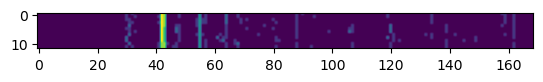

In [119]:
plt.imshow(M)

## Vector de características

In [43]:
from itertools import product

In [86]:
class vector_cadena:
    """
    Clase para vectorizar a partir de los n-gramas
    """
    #------------------------------------
    def __init__(self, lista, metodo='posicion', tam=2):
        """
        Constructor: el diccionario es una lista de letras permitidas 
        El feature space es un arreglo con todos los posibles n-gramas 
        """
        assert (metodo in ['frec','posicion','ambos'])
        
        self.conjunto      = lista.lower()
        self.__metodo__    = metodo
        self.__n__         = tam
        
        self.__ngramas__ = [''.join(gramema) for gramema in product(lista, repeat=tam)]
        self.__feat_space = dict(zip(self.__ngramas__, [0]*len(self.__ngramas__)))
        

    #------------------------------------    
    def genera_vector(self, cad, tipo='dict'):
        """
        Genera el vector de caracteristicas aplicado a
        la cadena cad usando el espacio de características
        definidas en el construtor
        
        - Parameters:
            cad: string para vectorizar
        
        - Returns:
            Vector con conteo de entradas
        """
        assert tipo in ('dict','array')
        fs = self.__feat_space.copy()
        k = self.__n__
        ngramas = self.__ngramas__
        vec = [cad[i:i+k] for i in range(0, len(cad)-k+1)]
        for v in vec:
            fs[v] += 1
        if(tipo=='dict'):
            return fs
        elif(tipo=='array'):
            return np.array(list(fs.values()))
    #------------------------------------    
    def genera_matriz(self, lista_cadenas, tipo='array'):
        """
        Genera los vectores de las 
        cadenas contenidas en lista_cadenas
        y los guarda en arreglo 

        - Parameters:
            lista_cadenas: Lista con cadenas

        - Returns:
            Array con vectores de características
        """
        assert tipo in ('array','dataframe')
        ngramas = self.__ngramas__
        k = len(self.__feat_space)
        matriz = np.zeros((len(lista_cadenas),k))
#         print(matriz.shape)
        for j, cad in enumerate(tqdm.tqdm(lista_cadenas)):
            v = self.genera_vector(cad, tipo='array')
            matriz[j] = v
        self.__matriz__ = matriz
        if(tipo=='array'):
            return matriz
        elif(tipo=='dataframe'):
            return pd.DataFrame(matriz, index=lista_cadenas)    
    #------------------------------------    
    def similitud_vectores(self, i,j, metrica='euclideana'):
        """
        Compara los vectores en las posiciones i y j
        - Parameters:
            i, j: entradas en la matriz calculada en genera_matriz

        - Returns:
            Float que indica la comparación entre los vectores matriz[i] y matriz[j]
            con el método en el parámetro
        """
        assert metrica in ['l2','l1', 'coseno',]
        matriz = self.__matriz__
        vec1, vec2 = matriz[i], matriz[j]
        if(metrica =='l1'):
            return np.linalg.norm(vec1 - vec2, 1)
        elif(metrica =='l2'):
            return np.linalg.norm(vec1 - vec2, 2)
        elif(metrica == 'coseno'):
            dot = np.dot(vec1, vec2)
            n1  = np.linalg.norm(vec1)
            n2  = np.linalg.norm(vec2)
            cs  = dot / (n1*n2)
            return cs
            
    #------------------------------------    
    def calcula_matriz_similitud(self, metrica='euclideana'):
        """
        Calcula la matriz con la similitud de la matriz de vectores 
        de caracteristicas previamente calculadas 
        
        - Parameters:
            
        - Returns:
            Float que indica la comparación entre los vectores matriz[i] y matriz[j]
            con el método en el parámetro
        """
        matriz = self.__matriz__
        N = np.zeros((len(matriz), len(matriz)))
        I,J = N.shape
        for i in range(I):
            vec1 = matriz[i]
            for j in range(I):
                vec2 = matriz[j]
                N[i,j] = self.similitud_vectores(i,j, metrica)
        self.comparacion_calculada = True
        self.comparacion = N
    #------------------------------------    
    def matriz_similitud(self, metrica='euclideana'):
        """
        Recupera la matriz calculada con calcula_matriz_similitud
        
        """
        if(self.comparacion_calculada):
            return self.comparacion
    #------------------------------------    
    @property
    def feat_space(self):
        return self.__ngramas__
    

 Primero instanciamos el objeto con los caracteres que pueden formar los folios, en nuestro caso este alfabeto es
 
     0 1 2 3 4 5 6 7 8 9 A F M _ 

In [153]:
caracteres = 'AFM/_0123456789'

In [158]:
C = vector_cadena(caracteres, tam=2)
C.feat_space 

['AA',
 'AF',
 'AM',
 'A/',
 'A_',
 'A0',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'FA',
 'FF',
 'FM',
 'F/',
 'F_',
 'F0',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'MA',
 'MF',
 'MM',
 'M/',
 'M_',
 'M0',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 '/A',
 '/F',
 '/M',
 '//',
 '/_',
 '/0',
 '/1',
 '/2',
 '/3',
 '/4',
 '/5',
 '/6',
 '/7',
 '/8',
 '/9',
 '_A',
 '_F',
 '_M',
 '_/',
 '__',
 '_0',
 '_1',
 '_2',
 '_3',
 '_4',
 '_5',
 '_6',
 '_7',
 '_8',
 '_9',
 '0A',
 '0F',
 '0M',
 '0/',
 '0_',
 '00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '1A',
 '1F',
 '1M',
 '1/',
 '1_',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2A',
 '2F',
 '2M',
 '2/',
 '2_',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3A',
 '3F',
 '3M',
 '3/',
 '3_',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4A',
 '4F',
 '4M',
 '4/',
 '4_',
 '40',
 '41',
 '42',

Ahora en C tenemos un objeto que puede generar vectores de características de cadenas. Vamos a generar 12 ejemplos tomados de la entidad antes tomada.

In [159]:
L =[folio1+'_39_1' ,folio2+'_40_1' ,folio3+'_23_1' ,folio4+'_30_2',
    folio5+'_29_2' ,folio6+'_23_1' ,folio7+'_45_2' ,folio8+'_27_2',
    folio9+'_16_1' ,folio10+'_12_1',folio11+'_20_2',folio12+'_30_1']
for folio in L:
    print(folio)

010010000193719001001206_39_1
010010000193719001001206_40_1
010010000193719001001211_23_1
010010000193719001001211_30_2
010010000193760501000601_29_2
010010000193760501000605_23_1
010010000193760501000605_45_2
010010000193717901000611_27_2
010010000193718301000616_16_1
010010000176318301000618_12_1
010010000193760501001202_20_2
010010000193760501001204_30_1


In [160]:
# por ejemplo para el primer folio las características son
C.genera_vector(L[1])

{'AA': 0,
 'AF': 0,
 'AM': 0,
 'A/': 0,
 'A_': 0,
 'A0': 0,
 'A1': 0,
 'A2': 0,
 'A3': 0,
 'A4': 0,
 'A5': 0,
 'A6': 0,
 'A7': 0,
 'A8': 0,
 'A9': 0,
 'FA': 0,
 'FF': 0,
 'FM': 0,
 'F/': 0,
 'F_': 0,
 'F0': 0,
 'F1': 0,
 'F2': 0,
 'F3': 0,
 'F4': 0,
 'F5': 0,
 'F6': 0,
 'F7': 0,
 'F8': 0,
 'F9': 0,
 'MA': 0,
 'MF': 0,
 'MM': 0,
 'M/': 0,
 'M_': 0,
 'M0': 0,
 'M1': 0,
 'M2': 0,
 'M3': 0,
 'M4': 0,
 'M5': 0,
 'M6': 0,
 'M7': 0,
 'M8': 0,
 'M9': 0,
 '/A': 0,
 '/F': 0,
 '/M': 0,
 '//': 0,
 '/_': 0,
 '/0': 0,
 '/1': 0,
 '/2': 0,
 '/3': 0,
 '/4': 0,
 '/5': 0,
 '/6': 0,
 '/7': 0,
 '/8': 0,
 '/9': 0,
 '_A': 0,
 '_F': 0,
 '_M': 0,
 '_/': 0,
 '__': 0,
 '_0': 0,
 '_1': 1,
 '_2': 0,
 '_3': 0,
 '_4': 1,
 '_5': 0,
 '_6': 0,
 '_7': 0,
 '_8': 0,
 '_9': 0,
 '0A': 0,
 '0F': 0,
 '0M': 0,
 '0/': 0,
 '0_': 1,
 '00': 6,
 '01': 5,
 '02': 0,
 '03': 0,
 '04': 0,
 '05': 0,
 '06': 1,
 '07': 0,
 '08': 0,
 '09': 0,
 '1A': 0,
 '1F': 0,
 '1M': 0,
 '1/': 0,
 '1_': 0,
 '10': 3,
 '11': 0,
 '12': 1,
 '13': 0,
 '14': 0,


In [161]:
# También podemos este vector como un array
C.genera_vector(L[0], 'array').shape

(225,)

Esto quiere decir que del 'bigrama' 00 hay 6 instancias, del 01 hay 5, etcétera. 

Podemos hacer esto para toda una lista de folios a probar de la siguiente manera:

In [167]:
# Se puede generar un dataframe o bien un arreglo
# Si la cantidad de características es muy grande no es aconsejable 
# generar el dataframe y mejor dejarlo como array
M = C.genera_matriz([x[9:] for x in L], 'array')

100%|██████████| 12/12 [00:00<00:00, 12041.06it/s]


In [168]:
M

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [170]:
M = C.genera_matriz([x[9:] for x in L], 'dataframe')
M # dataframe con las características asociadas a cada folio


100%|██████████| 12/12 [00:00<00:00, 12038.18it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224
193719001001206_39_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
193719001001206_40_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
193719001001211_23_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
193719001001211_30_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0

Para medirla similitud entre los vectores generados hay dos métricas

    - l1      : Suma de valores absolutos de los términos
    - l2      : Mientras más pequeño, quiere decir que los vectores son más cercanos
    - coseno  : Mientras más cercanos a 1 quiere decir que son más cercanos

A continuación se ejemplifican para dos casos ambos con las dos métricas

In [171]:
i,j = 0,1
print(L[i], L[j])
C.similitud_vectores(i,j, 'coseno'), C.similitud_vectores(i,j, 'l1'), C.similitud_vectores(i,j, 'l2')


010010000193719001001206_39_1 010010000193719001001206_40_1


(0.88, 6.0, 2.449489742783178)

In [172]:
i,j = 2,3
print(L[i], L[j])

C.similitud_vectores(i,j, 'coseno'), C.similitud_vectores(i,j, 'l1'), C.similitud_vectores(i,j, 'l2')


010010000193719001001211_23_1 010010000193719001001211_30_2


(0.88, 6.0, 2.449489742783178)

In [173]:
i,j = 0,10
print(L[i], L[j])

C.similitud_vectores(i,j, 'coseno'), C.similitud_vectores(i,j, 'l1'), C.similitud_vectores(i,j, 'l2')


010010000193719001001206_39_1 010010000193760501001202_20_2


(0.56, 20.0, 4.69041575982343)

Este proceso lo podemos hacer en automático para toda la matriz 

In [178]:
# Se calcula la similitud separada de la obtención 
C.calcula_matriz_similitud('l2')
# aquí se pide la matriz
S = C.matriz_similitud()

<Axes: >

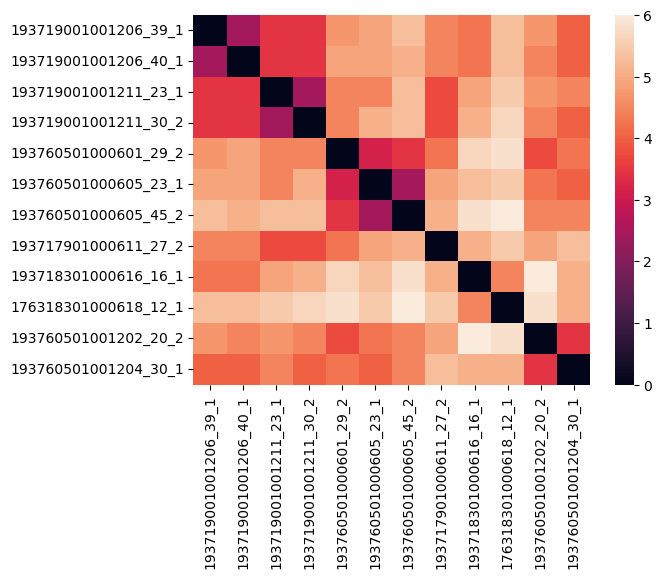

In [180]:
K = pd.DataFrame(S, index=[x[9:] for x in L], columns=[x[9:] for x in L])
sns.heatmap(K)